In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns

In [10]:
df = pd.read_csv('/kaggle/input/youtube-comments-dataset/YoutubeCommentsDataSet.csv')
df = df.convert_dtypes()

In [11]:
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [12]:
df.tail()

,Comment,Sentiment
18403,i really like the point about engineering tool...,positive
18404,i’ve just started exploring this field and thi...,positive
18405,excelente video con una pregunta filosófica pr...,neutral
18406,hey daniel just discovered your channel a coup...,positive
18407,this is great focus is key a playful approach ...,positive


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  string
 1   Sentiment  18408 non-null  string
dtypes: string(2)
memory usage: 287.8 KB


In [14]:
df.describe()

,Comment,Sentiment
count,18364,18408
unique,17871,3
top,one of the best thing about dude is that he ne...,positive
freq,10,11432


In [15]:
df.Sentiment.value_counts()

Sentiment
positive    11432
neutral      4638
negative     2338
Name: count, dtype: Int64

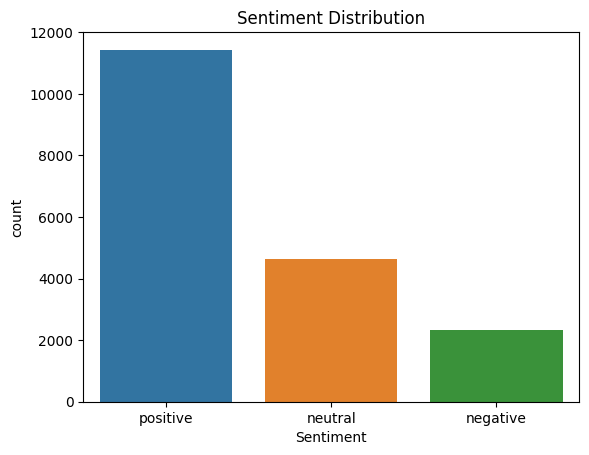

In [16]:
import matplotlib.pyplot as plt

sns.countplot(x='Sentiment', data=df, order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


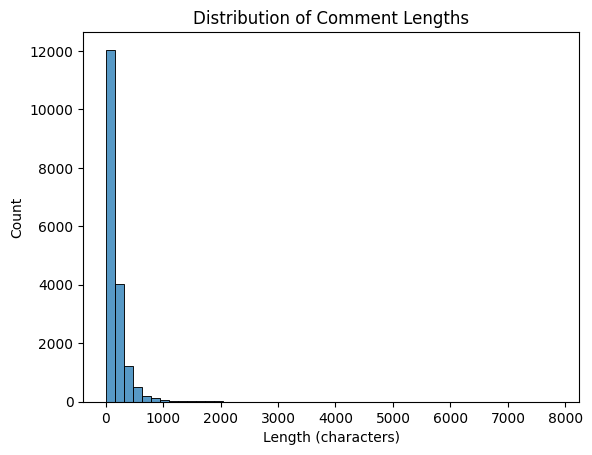

count       18364.0
mean     177.554128
std      251.049895
min             2.0
25%            66.0
50%           113.0
75%           201.0
max          7847.0
Name: Comment_Length, dtype: Float64


In [17]:
df['Comment_Length'] = df['Comment'].str.len()
sns.histplot(df['Comment_Length'].dropna(), bins=50)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Length (characters)')
plt.show()

# Summary statistics
print(df['Comment_Length'].describe())

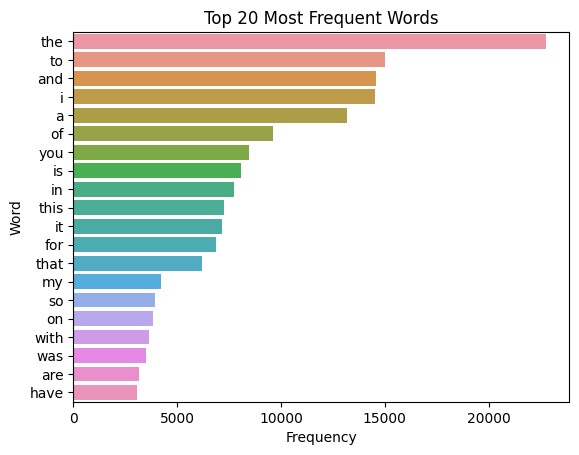

In [18]:
from collections import Counter
import re

# Combine all comments into one string, clean, and split into words
all_comments = ' '.join(df['Comment'].dropna()).lower()
words = re.findall(r'\w+', all_comments)
word_freq = Counter(words).most_common(20)

# Plot top words
words_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=words_df)
plt.title('Top 20 Most Frequent Words')
plt.show()

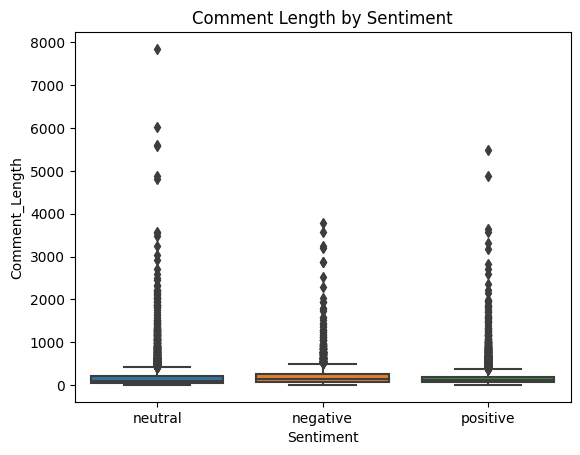

In [19]:
sns.boxplot(x='Sentiment', y='Comment_Length', data=df)
plt.title('Comment Length by Sentiment')
plt.show()

# Sentiment classification

Using device: cuda
GPU Name: Tesla T4
Original class distribution: Counter({'positive': 11402, 'neutral': 4625, 'negative': 2337})
Saved vectorizer and label encoder
Resampled class distribution: Counter({1: 11402, 0: 11402, 2: 11402})
Epoch 1/500, Train Loss: 1.0876, Val Loss: 1.0738, Train Acc: 0.4297, Val Acc: 0.5492
New best validation loss: 1.0738
Epoch 11/500, Train Loss: 0.6098, Val Loss: 0.6544, Train Acc: 0.8045, Val Acc: 0.7784
New best validation loss: 0.6544
Epoch 21/500, Train Loss: 0.4265, Val Loss: 0.5319, Train Acc: 0.8597, Val Acc: 0.8110
New best validation loss: 0.5319
Epoch 31/500, Train Loss: 0.3293, Val Loss: 0.4834, Train Acc: 0.8917, Val Acc: 0.8281
New best validation loss: 0.4834
Epoch 41/500, Train Loss: 0.2654, Val Loss: 0.4659, Train Acc: 0.9139, Val Acc: 0.8386
New best validation loss: 0.4659
No improvement in validation loss. Patience counter: 1/5
No improvement in validation loss. Patience counter: 2/5
No improvement in validation loss. Patience counter

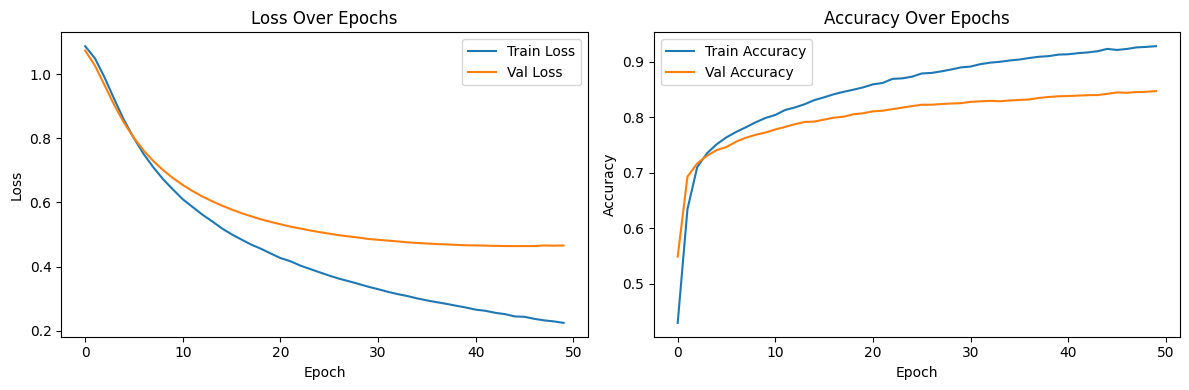

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt
import joblib  # Added for saving components

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, falling back to CPU.")

# Step 1: Load and Preprocess Data
df = pd.read_csv('/kaggle/input/youtube-comments-dataset/YoutubeCommentsDataSet.csv')
df = df.dropna(subset=['Comment'])  # Drop rows with missing comments
print("Original class distribution:", Counter(df['Sentiment']))

# Encode sentiment labels
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])  # positive: 2, neutral: 1, negative: 0

# Vectorize comments
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['Comment']).toarray()
y = df['Sentiment'].values

# Save the vectorizer and label encoder
joblib.dump(vectorizer, 'count_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Saved vectorizer and label encoder")

# Step 2: Oversampling to balance classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
print("Resampled class distribution:", Counter(y_resampled))

# Convert to PyTorch tensors
X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)

# Step 3: Split into Train, Validation, and Test Sets
X_temp, X_test, y_temp, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Custom Dataset Class
class CommentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
train_dataset = CommentDataset(X_train, y_train)
val_dataset = CommentDataset(X_val, y_val)
test_dataset = CommentDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Step 4: Define the Model
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Model parameters
input_dim = X_resampled.shape[1]  # Number of features (5000 from CountVectorizer)
hidden_dim = 128
output_dim = 3  # 3 classes: positive, neutral, negative

# Initialize model and move to GPU
model = SentimentClassifier(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

# Step 5: Training Loop with Early Stopping
num_epochs = 500
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    if (epoch % 10 == 0):
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')
    
    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        if (epoch % 10 == 0):
            print(f"New best validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered!")
            model.load_state_dict(best_model_state)
            break

# Step 6: Evaluate on Test Set with Best Model
model.eval()
test_loss = 0
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Step 7: Save the Best Model and training metadata
torch.save({
    'model_state_dict': best_model_state,
    'input_dim': input_dim,
    'hidden_dim': hidden_dim,
    'output_dim': output_dim,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_accuracy': test_accuracy
}, 'sentiment_classifier_full.pth')

print("Saved full model checkpoint and training metadata as 'sentiment_classifier_full.pth'")

# Step 8: Plot Training Metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')  # Save the plot
plt.show()

In [12]:
import torch
import torch.nn as nn
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Define the model architecture (must match training)
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def load_model_and_components():
    """Load all necessary components for inference"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model checkpoint
    checkpoint = torch.load('sentiment_classifier_full.pth', map_location=device)
    
    # Initialize model
    model = SentimentClassifier(
        input_dim=checkpoint['input_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        output_dim=checkpoint['output_dim']
    ).to(device)
    
    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Load other components
    vectorizer = joblib.load('count_vectorizer.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    
    return model, vectorizer, label_encoder, device

def predict_sentiment(comment, model, vectorizer, label_encoder, device='cpu'):
    """
    Predict sentiment of a single comment.
    Returns:
        dict: {'sentiment': 'positive/neutral/negative', 'probabilities': dict}
    """
    # Preprocess the input
    with torch.no_grad():
        # Vectorize the comment
        X = vectorizer.transform([comment]).toarray()
        X = torch.tensor(X, dtype=torch.float32).to(device)
        
        # Make prediction
        outputs = model(X)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted_class = torch.argmax(outputs, dim=1).cpu().numpy()[0]
        
        # Convert to human-readable labels
        sentiment = label_encoder.inverse_transform([predicted_class])[0]
        
        # Create probability dictionary
        class_probabilities = {
            label_encoder.inverse_transform([i])[0]: float(prob)
            for i, prob in enumerate(probabilities)
        }
        
        return {
            'sentiment': sentiment,
            'probabilities': class_probabilities
        }

# Example usage
if __name__ == "__main__":
    # Load everything
    model, vectorizer, label_encoder, device = load_model_and_components()
    
    # Example comments
    comments = [
        "I love this video! It's amazing!",
        "This is just okay, nothing special",
        "Terrible content, would not recommend",
        "The quality could be better but I like the concept"
        "I hate this content, it is worst ever"
    ]
    
    # Make predictions
    for comment in comments:
        result = predict_sentiment(comment, model, vectorizer, label_encoder, device)
        print(f"Comment: {comment}")
        print(f"Predicted sentiment: {result['sentiment']}")
        print(f"Probabilities: {result['probabilities']}")
        print("-" * 50)

Comment: I love this video! It's amazing!
Predicted sentiment: positive
Probabilities: {'negative': 0.0001206054657814093, 'neutral': 0.0002975305251311511, 'positive': 0.9995818734169006}
--------------------------------------------------
Comment: This is just okay, nothing special
Predicted sentiment: neutral
Probabilities: {'negative': 0.21063071489334106, 'neutral': 0.4987712502479553, 'positive': 0.2905980944633484}
--------------------------------------------------
Comment: Terrible content, would not recommend
Predicted sentiment: negative
Probabilities: {'negative': 0.7016617655754089, 'neutral': 0.18000327050685883, 'positive': 0.11833493411540985}
--------------------------------------------------
Comment: The quality could be better but I like the conceptI hate this content, it is worst ever
Predicted sentiment: negative
Probabilities: {'negative': 0.9948422312736511, 'neutral': 0.0013689775951206684, 'positive': 0.003788890317082405}
----------------------------------------

<ipython-input-12-c4301d5c4193>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('sentiment_classifier_full.pth', map_location=device)
